# Import Libraries

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import glob
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from datetime import timedelta
from matplotlib.ticker import ScalarFormatter, LogLocator
from matplotlib.ticker import FuncFormatter, LogLocator
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter, LogFormatter
from scipy.stats import zscore
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import pytz
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import io
import os
from pptx import Presentation
from pptx.util import Inches

# Set Plotting Parameters

Fontsize, linewidth, etc. Feel free to change these as you wish

In [4]:
np.set_printoptions(precision = 4)

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = '1.5'
mpl.rcParams['ytick.major.width'] = '1.5'
mpl.rcParams['xtick.minor.width'] = '1.0'
mpl.rcParams['xtick.minor.width'] = '1.0'
mpl.rcParams['xtick.major.size'] = '10.0'
mpl.rcParams['ytick.major.size'] = '10.0'
mpl.rcParams['xtick.minor.size'] = '5.0'
mpl.rcParams['ytick.minor.size'] = '5.0'
mpl.rcParams['axes.linewidth'] = '1.5'
mpl.rcParams['axes.labelsize'] = '20'
mpl.rcParams['axes.titlesize'] = '20' 
mpl.rcParams['figure.titlesize'] = '20'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'
mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

# Define paths

In [5]:
# Path to SMPS data file (the cleaned_csv saved at the end of code in cleaning_smps_csv_VIB.ipynb)
pathp = 'C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/smps_full_dataset_2023-08-04_to_2025-08-25.csv'

# # Path to folder in which you keep your Aethelometer csv files
# aeth_path = '/Users/vineblankenship/Research/ASCENT/AETHDataSummer2025'
#
# # Path to individual Aethelometer csv files for the concatenation step
# aeth_csv_files = glob.glob(aeth_path  + '/*.csv')

# output_folder is the destination folder of all of the plots below
output_folder = 'C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output'


# Define the dataframe as dfp (short for DataFrame Pico Rivera, in this case)

Load in the csv from the SMPS path defined above and define a time series dataframe for which the local_time column is the index 

In [6]:
dfp = pd.read_csv(pathp)

In [7]:
tsdfp = dfp.set_index('local_time')
tsdfp = tsdfp.sort_index()

# Locate Relevant Concentration Columns (This varies site to site and it is different for Shiny csv files versus csv files downloaded locally at sites)

In [8]:
tsdfp.columns[41:156] # your column range here

Index(['13.10', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.80', '661.17', '685.39', '710.50',
       '736.53', '763.51', '791.48'],
      dtype='str', length=115)

## Define the concentration_columns range as the range you have selected above

In [9]:
concentration_columns = slice(41, 156) # your column range here

# Calculations from original ASCENT SMPS code: 

Calculating dN/dlogDp at standard temperature and pressure (STP) 

In [10]:
# read diameter as array
mid_Dp = np.array([float(x) for x in tsdfp.columns[concentration_columns]]) # pico
avg_diffp = np.mean(np.diff(np.log10(mid_Dp)))

D_boundp = np.full(mid_Dp.shape[0]+1, np.nan)
for i in range (1, (len(D_boundp)-1)):
    D_boundp[i] = 10 ** (0.5 * (np.log10(mid_Dp[i])+np.log10(mid_Dp[i-1])))
    
D_boundp[0] = 10 ** (np.log10(mid_Dp[0]) - 0.5*avg_diffp)
D_boundp[-1] = 10 ** (np.log10(mid_Dp[-1]) + 0.5*avg_diffp)
D_lowp = D_boundp[0:-1]
D_highp = D_boundp[1:]
dlogDpp = np.log10(D_highp) - np.log10(D_lowp)

In [11]:
# STP conversion factor
STP_factorp = (101.35/tsdfp['Sheath Pressure (kPa)']) * ((273.15+tsdfp['Sheath Temp (C)'])/273.15)

In [12]:
# Check the column indices to ensure you run the calculations on the concentrations 
tsdfp.columns[concentration_columns]

Index(['13.10', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.80', '661.17', '685.39', '710.50',
       '736.53', '763.51', '791.48'],
      dtype='str', length=115)

## Define dNdlogDp_stpp, dVdlogDp_stpp, dMdlogDp_stpp, N_stp, V_stp, M_stp

In [13]:
# calculate total number of each scan 
artsdfp = np.array(tsdfp)

dNdlogDpp = artsdfp[:, concentration_columns] # pico

dNdlogDp_stpp = dNdlogDpp * np.array(STP_factorp)[:,None]

dN_stpp = dNdlogDp_stpp * dlogDpp

N_stp = np.nansum(dN_stpp, axis=1)

# # calculate volume distribution and total volume of each scan 
dVdlogDp_stpp = (np.pi/6.) * (mid_Dp/1e3) **3 * dNdlogDp_stpp  #um3/cm3

dV_stpp = dVdlogDp_stpp * dlogDpp

V_stp = np.nansum(dV_stpp, axis=1)         #um3/cm3

# calculate mass distribution and total mass of each scan by assuming a particle density
density = 1.0      #  g/cm³
dMdlogDp_stpp = (density/1e9) * (np.pi/6.) * mid_Dp**3 * dNdlogDp_stpp    #ug/m3

dM_stp = dMdlogDp_stpp * dlogDpp

M_stp = np.nansum(dM_stp, axis=1)         #ug/m3

print(dM_stp.shape)

(431271, 115)


## Monthly average dNdlogDp and dMdlogDp (exported images in a powerpoint)

In [25]:
# 1. Initialize the PowerPoint Presentation
prs = Presentation()

# 2. Prepare the data
# Ensure the index is datetime
if not isinstance(tsdfp.index, pd.DatetimeIndex):
    tsdfp.index = pd.to_datetime(tsdfp.index)

# Create temporary DataFrames for easier grouping
# We assume dNdlogDp_stpp and dMdlogDp_stpp align with tsdfp rows
df_dN = pd.DataFrame(dNdlogDp_stpp, index=tsdfp.index)
df_dM = pd.DataFrame(dMdlogDp_stpp, index=tsdfp.index)

# 3. Group by Month
# We use the index of one of them to define the groups
monthly_groups = df_dN.groupby(df_dN.index.to_period('M'))

print(f"Generating monthly distribution slides for {len(monthly_groups)} months...")

# 4. Loop through each month
for period, group_dN in monthly_groups:
    month_name = period.strftime('%B %Y')

    # Get the corresponding dM data for this month using the index
    group_dM = df_dM.loc[group_dN.index]

    # Calculate the mean across time (axis 0) for this month
    # This results in a 1D array of average distribution for the month
    avg_dN = group_dN.mean(axis=0).values
    avg_dM = group_dM.mean(axis=0).values

    # --- Create Figure with 2 Subplots (Top: dN, Bottom: dM) ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # ==========================================
    # PLOT 1: Average dN/dlogDp (Top)
    # ==========================================
    # mid_Dp is the diameter array from Cell 8
    ax1.plot(mid_Dp, avg_dN, color='tab:blue', linewidth=2)
    ax1.set_xscale('log')
    ax1.set_ylabel('dN/dlogDp (#/cm³)', fontsize=12)
    ax1.set_title(f'{month_name}: Average Number Size Distribution', fontsize=14)
    ax1.grid(True, which="both", linestyle='--', alpha=0.6)

    # ==========================================
    # PLOT 2: Average dM/dlogDp (Bottom)
    # ==========================================
    ax2.plot(mid_Dp, avg_dM, color='tab:red', linewidth=2)
    ax2.set_xscale('log')
    ax2.set_xlabel('Particle Diameter (nm)', fontsize=12)
    ax2.set_ylabel('dM/dlogDp (µg/m³)', fontsize=12)
    ax2.set_title(f'{month_name}: Average Mass Size Distribution', fontsize=14)
    ax2.grid(True, which="both", linestyle='--', alpha=0.6)

    plt.tight_layout()

    # --- Save Figure to Memory Buffer ---
    image_stream = io.BytesIO()
    plt.savefig(image_stream, format='png', dpi=150)
    image_stream.seek(0)
    plt.close(fig)

    # --- Add Slide to PowerPoint ---
    slide_layout = prs.slide_layouts[6] # Blank slide
    slide = prs.slides.add_slide(slide_layout)

    # Add a title text box for clarity (Optional)
    # txBox = slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(0.5))
    # txBox.text_frame.text = f"Distributions: {month_name}"

    # Center image on slide
    pic_height = Inches(7.0)
    left = Inches(1.5)
    top = Inches(0.25)

    slide.shapes.add_picture(image_stream, left, top, height=pic_height)

# 5. Save the Presentation
output_filename = 'Monthly_Size_Distributions_dN_dM.pptx'
output_pptx = os.path.join(output_folder, output_filename)
prs.save(output_pptx)

print(f"Presentation saved successfully to: {output_pptx}")

Generating monthly distribution slides for 25 months...
Presentation saved successfully to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Monthly_Size_Distributions_dN_dM.pptx


## Export dM and dMdlogDp to csv files

In [ ]:
# 1. Create a DataFrame for the mass distribution data
# We use the time index from tsdfp and the diameters (mid_Dp) as column headers
df_dM_stp = pd.DataFrame(dM_stp, index=tsdfp.index, columns=mid_Dp)
df_dMdlogDp = pd.DataFrame(dMdlogDp_stpp, index=tsdfp.index, columns=mid_Dp)

# 2. Construct the full output filename
# This uses the 'output_folder' variable defined earlier in your notebook
output_filename = os.path.join(output_folder, 'dMdlogDp_stpp_export.csv')
output_filename_dM = os.path.join(output_folder, 'dM_stp_export.csv')

# 3. Export to CSV
df_dMdlogDp.to_csv(output_filename)
df_dM_stp.to_csv(output_filename_dM)

## PM0.1 and PM1 calculations

In [26]:
# We convert the index to datetime to ensure resampling works, using 'coerce' to handle any bad timestamp strings
# tsdfp is from Cell 5
timestamps = pd.to_datetime(tsdfp.index, errors='coerce')
df_sums = pd.DataFrame(index=timestamps)

# Identify indices where the diameter (mid_Dp) is less than 105
# mid_Dp is the array of diameters corresponding to the columns of dM_stp
indices_lt_105 = np.where(mid_Dp < 105)[0]

# Identify indices where the diameter (mid_Dp) is greater than 50 nm for N50
indices_gt_50 = np.where(mid_Dp > 50)[0]

# Calculate the row-wise sums
# Sum of columns where Dp < 105 nm, meaning PM0.1 calculation (ultrafine particles, pm_f)
pm_upf = np.nansum(dM_stp[:, indices_lt_105], axis=1)

# Sum of all columns, meaning PM1 calculation (fine particles, pm_f)
pm_f = np.nansum(dM_stp, axis=1)

# Calculate N50: Sum of columns where Dp > 50 nm using dN (dN_stpp)
n50_val = np.nansum(dN_stpp[:, indices_gt_50], axis=1)

# Create a DataFrame with the results
# We use the index from tsdfp to ensure the timestamps align correctly
df_sums['PM0.1'] = pm_upf
df_sums['PM1'] = pm_f
df_sums['N10'] = N_stp
df_sums['N50'] = n50_val

# Resample to Hourly Averages
# 'H' stands for hourly frequency. We use mean() to get the average concentration per hour.
df_hourly = df_sums.resample('1h').mean()

# Drop any empty hours (optional, keeps plot clean)
df_hourly = df_hourly.dropna()

# Export to CSV
output_filename_hourly = os.path.join(output_folder, 'hourly_averages.csv')
df_hourly.to_csv(output_filename_hourly)

print(df_hourly)

                            PM0.1        PM1           N10           N50
local_time                                                              
2023-08-04 12:00:00  2.334003e-07   0.000110      0.004979      0.003334
2023-08-04 13:00:00  1.239328e+00   8.233139  11977.459650   6814.787840
2023-08-04 14:00:00  2.093302e+00  10.769883  24848.360530  10811.473108
2023-08-04 15:00:00  1.690785e+00  10.101016  24815.642506   8401.474394
2023-08-04 16:00:00  1.359770e+00   9.190854  24120.393038   6575.340251
...                           ...        ...           ...           ...
2025-08-25 10:00:00  6.710086e-01  10.656133  10408.617425   4138.685998
2025-08-25 11:00:00  8.148654e-01  10.660779  11684.033143   4895.570909
2025-08-25 12:00:00  1.047397e+00  11.726390  14474.423216   6022.677042
2025-08-25 13:00:00  1.542287e+00  11.902966  18965.149888   8853.831363
2025-08-25 14:00:00  2.784114e+00  13.145464  29054.888292  14863.092960

[18049 rows x 4 columns]


## Plot hourly PM0.1 vs PM1 for the whole data file

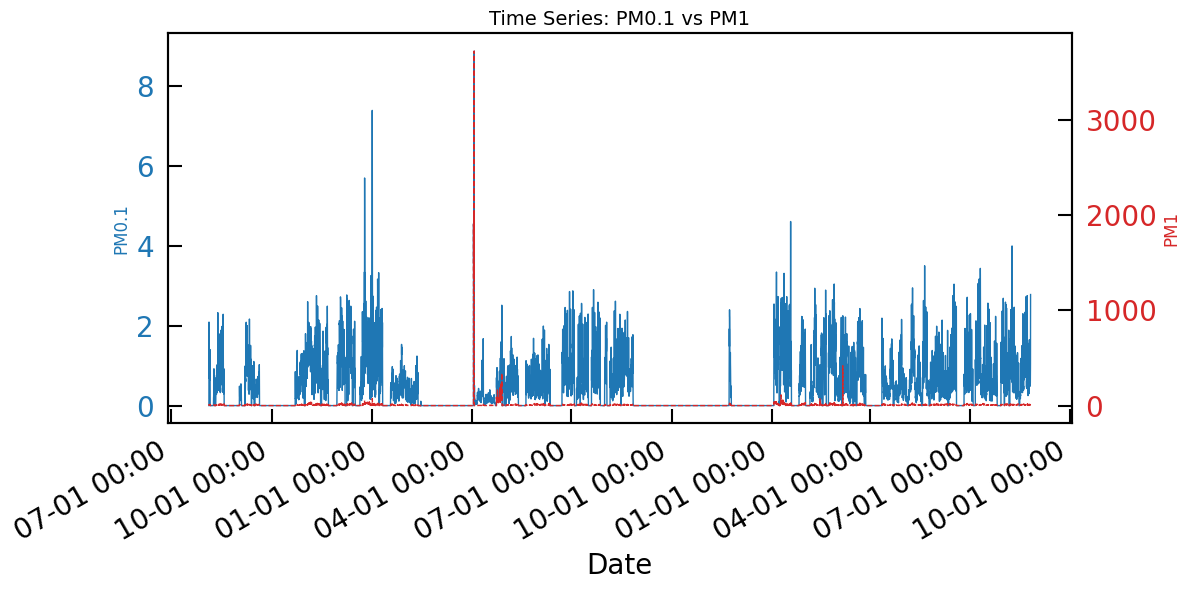

In [18]:
# 1. Create the figure and primary axis (left)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'PM0.1' on the left axis (Blue)
color_left = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('PM0.1', color=color_left, fontsize=12)
ax1.plot(df_hourly.index, df_hourly['PM0.1'], color=color_left, linewidth=1, label='PM0.1')
ax1.tick_params(axis='y', labelcolor=color_left)

# 2. Create the secondary axis (right) that shares the x-axis
ax2 = ax1.twinx()

# Plot 'PM1' on the right axis (Red)
color_right = 'tab:red'
ax2.set_ylabel('PM1', color=color_right, fontsize=12)
ax2.plot(df_hourly.index, df_hourly['PM1'], color=color_right, linewidth=1, linestyle='--', label='PM1')
ax2.tick_params(axis='y', labelcolor=color_right)

# 3. Formatting the Date Axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate() # Rotation

# 4. Title and Layout
plt.title('Time Series: PM0.1 vs PM1', fontsize=14)
fig.tight_layout()
plt.show()

## Plot hourly PM0.1 vs PM1 and N10 monthly timeseries and scatterplot and export the graphs in a powerpoint

In [27]:
# Ensure timestamps are datetime
timestamps = pd.to_datetime(tsdfp.index, errors='coerce')
df_sums = pd.DataFrame(index=timestamps)

# Identify indices for diameter ranges
# mid_Dp comes from the earlier cells in your notebook
indices_lt_105 = np.where(mid_Dp < 105)[0] # PM0.1 (Dp < 105 nm)
indices_gt_50 = np.where(mid_Dp > 50)[0]   # N50 (Dp > 50 nm)

# Calculate row-wise sums
# Mass sums (assuming dM_stp exists from previous steps)
pm_upf = np.nansum(dM_stp[:, indices_lt_105], axis=1) # PM0.1
pm_f = np.nansum(dM_stp, axis=1)                      # PM1

# Number sums (assuming dN_stpp exists from previous steps)
# N10 is essentially Total Number (all bins)
n10_val = N_stp
# N50 is Sum of dN for bins > 50 nm
n50_val = np.nansum(dN_stpp[:, indices_gt_50], axis=1)

# Store in DataFrame
df_sums['PM0.1'] = pm_upf
df_sums['PM1'] = pm_f
df_sums['N10'] = n10_val
df_sums['N50'] = n50_val

# Resample to Hourly Averages
df_hourly = df_sums.resample('1h').mean()
df_hourly = df_hourly.dropna()

# Export to CSV (optional, as per original Cell 24)
output_filename_hourly = os.path.join(output_folder, 'hourly_averages_with_N50.csv')
df_hourly.to_csv(output_filename_hourly)
print("Hourly averages (including N50) calculated and saved.")

# ==========================================
# PART 2: PowerPoint Generation
# ==========================================

# Initialize Presentation
prs = Presentation()

# Group data by Month
df_hourly.index = pd.to_datetime(df_hourly.index)
monthly_groups = df_hourly.groupby(df_hourly.index.to_period('M'))

# Helper Function for 3-Panel Slide
def create_three_panel_slide(prs, df_data, month_name, col_y1, col_y2, y1_label, y2_label, y2_color):
    """
    Creates a slide with:
    - Top: Time Series (spanning width)
    - Bottom Left: Scatter Plot
    - Bottom Right: Diurnal Plot
    """

    # --- 1. Statistics ---
    valid_data = df_data[[col_y1, col_y2]].dropna()
    if len(valid_data) > 1:
        corr = valid_data[col_y1].corr(valid_data[col_y2])
        r_squared = corr ** 2
    else:
        r_squared = 0.0

    diurnal_df = df_data.groupby(df_data.index.hour)[[col_y1, col_y2]].mean()

    # --- 2. Figure Setup ---
    fig = plt.figure(figsize=(13, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], hspace=0.35, wspace=0.25)

    # --- PLOT 1: Time Series (TOP) ---
    ax1 = fig.add_subplot(gs[0, :])

    color_left = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(y1_label, color=color_left, fontsize=12)
    ax1.plot(df_data.index, df_data[col_y1], color=color_left, linewidth=1, label=y1_label)
    ax1.tick_params(axis='y', labelcolor=color_left)

    ax2 = ax1.twinx()
    ax2.set_ylabel(y2_label, color=y2_color, fontsize=12)
    ax2.plot(df_data.index, df_data[col_y2], color=y2_color, linewidth=1, linestyle='--', label=y2_label)
    ax2.tick_params(axis='y', labelcolor=y2_color)

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    fig.autofmt_xdate(rotation=0)
    ax1.set_title(f'Time Series: {month_name} ({y1_label} vs {y2_label})', fontsize=14)
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- PLOT 2: Scatter Plot (BOTTOM LEFT) ---
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.scatter(df_data[col_y1], df_data[col_y2], alpha=0.6, color='purple', edgecolors='w', s=40)
    ax3.set_xlabel(f'{y1_label}')
    ax3.set_ylabel(f'{y2_label}')
    ax3.set_title(f'Correlation ($R^2 = {r_squared:.3f}$)', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.6)

    # --- PLOT 3: Diurnal Plot (BOTTOM RIGHT) ---
    ax4 = fig.add_subplot(gs[1, 1])

    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel(y1_label, color=color_left, fontsize=12)
    ax4.plot(diurnal_df.index, diurnal_df[col_y1], color=color_left, linewidth=2, marker='o', markersize=4)
    ax4.tick_params(axis='y', labelcolor=color_left)

    ax5 = ax4.twinx()
    ax5.set_ylabel(y2_label, color=y2_color, fontsize=12)
    ax5.plot(diurnal_df.index, diurnal_df[col_y2], color=y2_color, linewidth=2, linestyle='--', marker='s', markersize=4)
    ax5.tick_params(axis='y', labelcolor=y2_color)

    ax4.set_xticks(range(0, 24, 4))
    ax4.set_xlim(0, 23)
    ax4.set_title(f'Diurnal Profile', fontsize=12)
    ax4.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()

    # --- Save to Slide ---
    image_stream = io.BytesIO()
    plt.savefig(image_stream, format='png', dpi=150)
    image_stream.seek(0)
    plt.close(fig)

    slide_layout = prs.slide_layouts[6] # Blank slide
    slide = prs.slides.add_slide(slide_layout)

    pic_height = Inches(7.0)
    # Center on 10-inch slide (approx width 9.1 inches)
    left = Inches(0.45)
    top = Inches(0.25)

    slide.shapes.add_picture(image_stream, left, top, height=pic_height)


# Main Loop
print(f"Generating 3-slide sets for {len(monthly_groups)} months...")

for period, df_month in monthly_groups:
    month_name = period.strftime('%B %Y')

    # 1. PM0.1 vs PM1 (Red)
    create_three_panel_slide(
        prs, df_month, month_name,
        'PM0.1', 'PM1', 'PM0.1', 'PM1', 'tab:red'
    )

    # 2. PM0.1 vs N10 (Black)
    create_three_panel_slide(
        prs, df_month, month_name,
        'PM0.1', 'N10', 'PM0.1', 'N10', 'black'
    )

    # 3. PM0.1 vs N50 (Purple)
    create_three_panel_slide(
        prs, df_month, month_name,
        'PM0.1', 'N50', 'PM0.1', 'N50', 'tab:purple'
    )

# Save
output_pptx = os.path.join(output_folder, 'Monthly_Analysis_PM_N10_N50.pptx')
prs.save(output_pptx)
print(f"Presentation saved successfully to: {output_pptx}")

Hourly averages (including N50) calculated and saved.
Generating 3-slide sets for 25 months...


C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_1816\1801817638.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_1816\1801817638.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_1816\1801817638.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_1816\1801817638.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_1816\1801817638.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

Presentation saved successfully to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Monthly_Analysis_PM_N10_N50.pptx


In [ ]:
dNdlogDp_stpp.shape

In [ ]:
# Add N_stp array to the corresponding DataFrame
dfp['N_stp'] = N_stp


# Add Black Carbon Data

## Concatenate all csv files in a folder for Aethelometer data

In [ ]:
# concatenate
df_list = (pd.read_csv(file) for file in aeth_csv_files)

# Concatenate all DataFrames
dfb   = pd.concat(df_list, ignore_index=True).drop_duplicates().reset_index(drop=True)
dfb['time'] = pd.to_datetime(dfb['time'], format='%Y-%m-%d %H:%M:%S')

## Convert to local time

In [ ]:
def convert_to_local(df):

    dfb_local = df.copy()

    # Local timezone (replace with your local timezone)
    source_timezone = pytz.timezone('UTC')
    local_timezone = pytz.timezone('America/Los_Angeles')

    # Use the tz_convert function to convert the datetime column
    dfb_local['time'] = df['time'].dt.tz_localize(source_timezone).dt.tz_convert(local_timezone)
    dfb_local['time'] = pd.to_datetime(dfb_local["time"].dt.strftime('%Y-%m-%d %H:%M:%S'))

    dfb_local.rename(columns={'time':'local_time_bc'}, inplace=True)
    return dfb_local

## Call the local time conversion function, convert_to_local, to get the new df, dfb_local, which has the aethelometer data now in local time

In [ ]:
dfb_local = convert_to_local(dfb)

Calculate the rolling 30 minute average of the vehicular black carbon concentration (EBC_6 in aethelometer data)

Make a merged dataframe which contains both SMPS and Aethelometer data across consistent timestamps

Add a column to the original SMPS dataframe which represents the rolling 30 minute average black carbon, here titled 30_min_avg (from the column EBC_6 in aethelometer data) 

In [ ]:


# --- Step 1: Ensure datetime and set index for rolling calculation ---
dfb_local['local_time_bc'] = pd.to_datetime(dfb_local['local_time_bc'])
dfb_local = dfb_local.sort_values('local_time_bc').set_index('local_time_bc')

# --- Step 2: Calculate rolling 30-min average for EBC_6 ---
dfb_local['30_min_avg'] = dfb_local['EBC_6'].rolling('30T').mean()

# --- Step 3: Reset index so local_time_bc is a column again ---
dfb_local = dfb_local.reset_index()

# --- Step 4: Ensure dfp datetime is correct ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])

# --- Step 5: Merge using merge_asof ---
merged_df = pd.merge_asof(
    dfp.sort_values('local_time'),
    dfb_local[['local_time_bc', '30_min_avg']].sort_values('local_time_bc'),
    left_on='local_time',
    right_on='local_time_bc',
    direction='nearest',
    suffixes=('', '_bc')  # avoid naming conflicts
)


# --- Step 6: Add the rolling average column to dfp ---
if '30_min_avg' in merged_df.columns:
    dfp['30_min_avg'] = merged_df['30_min_avg']
else:
    raise KeyError("⚠ '30_min_avg' not found in merged_df. Check dfb_local generation.")

print(dfp[['local_time', '30_min_avg']].head())

In [ ]:
dfp # can check to ensure 30_min_avg column was added to dfp here

# Plotting Section 

## Time series colormap plot for every day in the dataset (x=time, y=diameter (nm), z=dNdlogDp)

Here, I use a warped colormap (a cubic function instead of linear) which emphasizes the variation in the high concentrations

In [ ]:
# --- Warped colormap setup ---
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Color list
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa', 
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap = warp_colormap(base_cmap, high_end_bias)

# --- Data setup ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])
dfp['date'] = dfp['local_time'].dt.date

# Meshgrid setup (once, reused)
Time = pd.to_datetime(dfp['local_time'])
X = mdates.date2num(Time)
Y = mid_Dp.copy()
XX, YY = np.meshgrid(X, Y)
Z = dNdlogDp_stpp.copy().T
Z_all = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))

# --- Daily plot loop ---
plot_counter = 0
grouped = dfp.groupby('date')



os.makedirs(output_folder, exist_ok=True)  # Ensure folder exists

for date, group in grouped:
    day_mask = dfp['date'] == date
    x_day = X[day_mask]
    z_day = Z_all[:, day_mask]

    fig, ax1 = plt.subplots(figsize=(16, 5))
    pcm = ax1.pcolormesh(x_day, YY[:, :z_day.shape[1]], z_day, shading='auto',
                         cmap=custom_cmap, norm=LogNorm(vmin=10, vmax=1e5)) # jt

    cbar = fig.colorbar(pcm, ax=ax1)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')    

    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)

    # Custom y-tick locations and labels
    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))

    ax1.set_ylabel('Dp (nm)')
    ax1.set_xlabel('local_time')
    ax1.tick_params(axis='both', which='major')

    ax1.xaxis.set_major_formatter(DateFormatter('%H'))
    ax1.set_xlim(x_day[0], x_day[-1])
    
    ax1.set_title(f'test pico SMPS - {date}')    

    plt.tight_layout()

    # Save only once here
    filename = os.path.join(output_folder, f'pico_time_series_{date}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Close to free memory, no need to call plt.show()

    plot_counter += 1

print(f'Number of days plotted: {plot_counter}')

# Plot with 4 time series in the top plots and their respective N_stps in the lower plots

In [ ]:
# Move to other code, keep this one too 
# --- Warped colormap setup ---
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3


# Color list
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa', 
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

custom_cmap = warp_colormap(base_cmap, high_end_bias)




def get_day_data(df, Z_all, mid_Dp, date_str):
    date = pd.to_datetime(date_str).date()
    df = df.copy()
    df['local_time'] = pd.to_datetime(df['local_time'])
    df['date'] = df['local_time'].dt.date

    mask = df['date'] == date

    if mask.sum() == 0:
        raise ValueError(f"No data found for date {date_str} in the dataframe.")

    df_day = df[mask]
    X = mdates.date2num(df_day['local_time'])

    z_day = Z_all[:, mask.values]  # Use .values to index numpy array

    return X, mid_Dp, z_day, df_day
# Define which days and sites to show
plot_info = [
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-04', 'Pico Rivera - Example 1', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-05', 'Pico Rivera - Example 2', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-06', 'Pico Rivera - Example 3', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-07', 'Pico Rivera - Example 4', 1e5),
]



fig = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 2, height_ratios=[3, 2, 3, 2], hspace=0.75, wspace=0.3)

for i, (df, Z, mid_D, date, name, vmax) in enumerate(plot_info):
    Z_masked = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))
    X, Y, z_day, df_day = get_day_data(df, Z_masked, mid_D, date)

    col_row = 0 if i < 2 else 2
    col_col = i % 2

    start = pd.to_datetime(date + ' 00:00')
    end = pd.to_datetime(date + ' 23:59')

    # meshgrid for pcolormesh
    XX, YY = np.meshgrid(X, Y)

    # --- Colormap plot ---
    ax1 = fig.add_subplot(gs[col_row, col_col])
    pcm = ax1.pcolormesh(XX, YY, z_day, shading='auto',
                         cmap=custom_cmap, norm=LogNorm(vmin=10, vmax=vmax))
    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)
    ax1.set_xlim(start, end)
    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))
    ax1.set_ylabel('Dp (nm)')
    ax1.set_title(f'{name} - {date}')

    def log_tick_formatter(val, pos=None):
        exponent = int(np.log10(val))
        return f'$10^{{{exponent}}}$'

    cbar = fig.colorbar(pcm, ax=ax1, pad=0.01, aspect=30)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')

    cbar.ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

    # --- Mean magnitude plot ---
    ax2 = fig.add_subplot(gs[col_row + 1, col_col], sharex=ax1)
    ax2.plot(df_day['local_time'], df_day['N_stp'], color='black', lw=2)
    ax2.set_ylabel('Total N (# cm$^{-3}$)')

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.set_xlim(start, end)

    ax2.set_xlabel('local_time')


    # Align bottom plot width to top plot width
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos1.x0, pos2.y0, pos1.width, pos2.height])


plt.tight_layout(rect=[0, 0, 0.9, 1])
filename = os.path.join(output_folder, f'pico_4_panel_event_plot_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()


## Plot with time series with black carbon (30_min_avg) in bottom plot (1 figure per day)

In [ ]:
# --- Data setup ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])
dfp['date'] = dfp['local_time'].dt.date

# Ensure dfp and SMPS are aligned
assert dfp.shape[0] == dNdlogDp_stpp.shape[0], "Mismatch between dfp and SMPS data!"

# Meshgrid setup (once, reused)
Time = pd.to_datetime(dfp['local_time'])
X = mdates.date2num(Time)
Y = mid_Dp.copy()
Z = dNdlogDp_stpp.copy().T  # Shape: (sizes, timestamps)
Z_all = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))

# --- Daily plot loop ---
plot_counter = 0
grouped = dfp.groupby('date')

os.makedirs(output_folder, exist_ok=True)  # Ensure folder exists

for date, group in grouped:
    # Mask for this date
    day_mask = dfp['date'] == date
    x_day = X[day_mask]
    z_day = Z_all[:, day_mask]

    if z_day.shape[1] == 0:
        continue

    black_carbon = dfp.loc[day_mask, '30_min_avg'].values

    start = pd.to_datetime(str(date) + ' 00:00')
    end = pd.to_datetime(str(date) + ' 23:59')

    # --- Create figure with two panels ---
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    # --- Top: SMPS heatmap ---
    ax1 = fig.add_subplot(gs[0])
    XX, YY = np.meshgrid(x_day, Y)
    pcm = ax1.pcolormesh(XX, YY[:, :z_day.shape[1]], z_day,
                         shading='auto', cmap=custom_cmap,
                         norm=LogNorm(vmin=10, vmax=1e5))
    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)
    ax1.set_xlim(start, end)

    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))
    ax1.set_ylabel('Dp (nm)')
    ax1.set_title(f'SMPS + Black Carbon - {date}')
    ax1.tick_params(axis='x', labelbottom=False)

    # Colorbar
    cbar = fig.colorbar(pcm, ax=ax1, pad=0.01, aspect=30)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')

    # --- Bottom: Black Carbon ---
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(dfp.loc[day_mask, 'local_time'], black_carbon, color='red', lw=2)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylabel('Black Carbon\n(µg/m³)')
    ax2.set_xlim(start, end)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.set_xlabel('local_time')

    # --- Align subplot widths ---
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos1.x0, pos2.y0, pos1.width, pos2.height])

    # Save figure
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    filename = os.path.join(output_folder, f'time_series_plot_with_bc_{date}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    plot_counter += 1

print(f'Number of days plotted: {plot_counter}')

# Average N_stp over whole dataset (Weekend Versus Weekday)

In [ ]:
# Move to other code, keep this here
lower_p = dfp['N_stp'].quantile(0.01)
upper_p = dfp['N_stp'].quantile(0.99)
dfp_no_outliers = dfp[(dfp['N_stp'] >= lower_p) & (dfp['N_stp'] <= upper_p)].copy()

# Make sure hour and dayofweek columns exist in the filtered dataframes
for df in [dfp_no_outliers, dfp_no_outliers]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek  # Monday=0, Sunday=6
    
# Create weekday and weekend masks
weekday_mask_p = dfp_no_outliers['dayofweek'].isin(range(5))  # 0-4
weekend_mask_p = dfp_no_outliers['dayofweek'].isin([5,6])     # 5-6

# Group by hour and take mean N_stp for weekdays and weekends
weekday_p = dfp_no_outliers[weekday_mask_p].groupby('hour')['N_stp'].mean()
weekend_p = dfp_no_outliers[weekend_mask_p].groupby('hour')['N_stp'].mean()

#################
# After filtering and adding 'hour' and 'dayofweek' columns (dfp_no_outliers and dfp_no_outliers)...

# Print samples for Pico Rivera (dfp_no_outliers)
print("Pico Rivera Sample Weekday Dates (with weekday name):")
for d in dfp_no_outliers[weekday_mask_p]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

print("\nPico Rivera Sample Weekend Dates (with weekday name):")
for d in dfp_no_outliers[weekend_mask_p]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

#################

# Plot the results
plt.figure(figsize=(12, 6))

plt.plot(weekday_p.index, weekday_p, label='Pico Rivera - Weekday', color='tab:blue', linewidth=2)
plt.plot(weekend_p.index, weekend_p, label='Pico Rivera - Weekend', color='tab:blue', linestyle='--', linewidth=2)

plt.xlabel('Hour of Day')
plt.ylabel('Mean N_stp (#/cm³)')

plt.title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera (Outliers Removed)')

plt.legend()

plt.grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 23)
plt.xticks(range(0, 24))  # Show all hours 0 through 23

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_N_stp_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

## Average N_stp and BC (30_min_avg) over whole dataset (Weekend Versus Weekday)

In [ ]:
# --- 1️⃣ Function to remove outliers ---
def remove_outliers(df, column):
    lower = df[column].quantile(0.01)
    upper = df[column].quantile(0.99)
    return df[(df[column] >= lower) & (df[column] <= upper)].copy()

# --- 2️⃣ Remove outliers for N_stp and BC ---
df_nstp = remove_outliers(dfp, 'N_stp')
df_bc = remove_outliers(dfp, '30_min_avg')

# --- 3️⃣ Convert time column to datetime and extract hour/dayofweek ---
for df in [df_nstp, df_bc]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek  # Monday=0, Sunday=6

# --- 4️⃣ Weekday/weekend masks ---
weekday_mask_n = df_nstp['dayofweek'].isin(range(5))
weekend_mask_n = df_nstp['dayofweek'].isin([5,6])

weekday_mask_bc = df_bc['dayofweek'].isin(range(5))
weekend_mask_bc = df_bc['dayofweek'].isin([5,6])

# --- 5️⃣ Compute hourly means ---
weekday_nstp = df_nstp[weekday_mask_n].groupby('hour')['N_stp'].mean()
weekend_nstp = df_nstp[weekend_mask_n].groupby('hour')['N_stp'].mean()

weekday_bc = df_bc[weekday_mask_bc].groupby('hour')['30_min_avg'].mean()
weekend_bc = df_bc[weekend_mask_bc].groupby('hour')['30_min_avg'].mean()

# --- 6️⃣ Plot both variables in stacked subplots ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# N_stp Plot
axes[0].plot(weekday_nstp.index, weekday_nstp, label='Weekday', color='tab:blue', linewidth=2)
axes[0].plot(weekend_nstp.index, weekend_nstp, label='Weekend', color='tab:blue', linestyle='--', linewidth=2)
axes[0].set_ylabel('Mean N_stp (#/cm³)')

axes[0].set_title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera (Outliers Removed)')

axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

# BC Plot
axes[1].plot(weekday_bc.index, weekday_bc, label='Weekday', color='tab:red', linewidth=2)
axes[1].plot(weekend_bc.index, weekend_bc, label='Weekend', color='tab:red', linestyle='--', linewidth=2)
axes[1].set_ylabel('Mean BC (µg/m³)')
axes[1].set_xlabel('Hour of Day')
axes[1].set_title('Weekday vs. Weekend Diurnal BC — Pico Rivera (Outliers Removed)')

axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_N_stp_BC_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()



# Event Frequency

- These are estimated frequencies, you will need to define your own how you wish

- Feel free to change the frequencies here and even the variable name from pico_freq, just be sure to change the varable name from pico_freq to the name you picked in this line: bars1 = ax.bar(x, pico_freq, width, label='Pico Rivera', color='#1f77b4')  


In [ ]:
# Example data
event_types = ['Daytime', 'Nighttime', 'Non-event'] # these can have different names
pico_freq = [0.13333333333333333, 0.45555555555555555, 0.45555555555555555] # change the frequencies
x = np.arange(len(event_types))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x, pico_freq, width, label='Pico Rivera', color='#1f77b4')

# Labels and styling
ax.set_ylabel('Frequency')
ax.set_title('Event Type Frequencies')
ax.set_xticks(x)
ax.set_xticklabels(event_types)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5, axis='y')

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_event_frequencies.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


# Average Particle size distributions

Calculate the average size distributions during the day (9am to 8pm) and night (9pm to 8am) 

Divide the dataset into day and night, and then calculate the average size distributions during those time periods for the whole dataset

In [ ]:
df_copyp = tsdfp.copy()

In [ ]:

df_copyp.columns[concentration_columns]

## Start with the taking the average dNdlogDp across all times for Pico Rivera and Rubidoux

In [ ]:
# Change columns here if needed
selected_colsp = df_copyp.columns[concentration_columns]
bin_diametersp = np.array(selected_colsp).astype(float)
dNdlogDp_stpp_numeric = np.array(dNdlogDp_stpp, dtype='float')
# Mask out bins with all NaNs
valid_binsp = ~np.all(np.isnan(dNdlogDp_stpp_numeric), axis=0)

# Compute average across time for valid bins
mean_spectrum_p = np.nanmean(dNdlogDp_stpp_numeric[:, valid_binsp], axis=0)
bin_diameters_validp = bin_diametersp[valid_binsp]


## Calculate the average size distributions during the day (9am to 8pm) and night (9pm to 8am) 

In [ ]:
df_copyp = df_copyp.reset_index()

In [ ]:
df_copyp

In [ ]:
# Convert timestamp column to datetime, if not already
df_copyp['local_time'] = pd.to_datetime(df_copyp['local_time'])

# Extract hour
df_copyp['hour'] = df_copyp['local_time'].dt.hour

In [ ]:
# Daytime: 09:00–20:00
day_maskp = df_copyp['hour'].between(9, 20)

# Nighttime: 21:00–23:59 and 00:00–08:59
night_maskp = ~day_maskp  # everything else

In [ ]:
# Convert dNdlogDp_stpp to numeric if not already done
dNdlogDp_stpp_numeric = pd.DataFrame(dNdlogDp_stpp).apply(pd.to_numeric, errors='coerce').values

# Apply masks to get subsets
dNdlogDp_dayp = dNdlogDp_stpp_numeric[day_maskp.values]
dNdlogDp_nightp = dNdlogDp_stpp_numeric[night_maskp.values]

In [ ]:
mean_dayp = np.nanmean(dNdlogDp_dayp, axis=0)
mean_nightp = np.nanmean(dNdlogDp_nightp, axis=0)

## Plot the total and day/night averages on same figure

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 cols, share y-axis

# First subplot: Average size distribution comparison
axes[0].plot(bin_diameters_validp, mean_spectrum_p, marker='o', label='Pico Rivera', color='blue')


axes[0].set_xscale('log')
axes[0].set_xlabel('Particle Diameter (nm)')
axes[0].set_ylabel('Mean dN/dlogDp (#/cm³)')
axes[0].set_title('Average Particle Size Distribution')

axes[0].tick_params(axis='both', which='major')

axes[0].grid(True, which='both', linestyle='--', alpha=0.5)
axes[0].set_xticks([10, 100])

axes[0].legend()


# Second subplot: Day vs Night for both sites
axes[1].plot(bin_diameters_validp, mean_dayp, label='Pico Day (9am–8pm)', color='blue', linewidth=3)
axes[1].plot(bin_diameters_validp, mean_nightp, label='Pico Night (9pm–8am)', color='blue', linestyle='--', linewidth=3)

axes[1].set_xscale('log')
axes[1].set_xlabel('Particle Diameter (nm)')
axes[1].set_title('Day vs Night Particle Size Distribution')
axes[1].tick_params(axis='both', which='major')

axes[1].grid(True, which='both', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_day_vs_night_dNdlogDp.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

## Average Total Number Concentration per Weekday

In [ ]:
dfp['local_time'] = pd.to_datetime(dfp['local_time'], errors='coerce')
dfp = dfp.set_index('local_time')
dfp = dfp.dropna(subset=['N_stp'])
dfp['weekday'] = dfp.index.day_name()

# Remove outliers using z-score
dfp_copy = dfp.copy()
dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['N_stp'].astype(float), nan_policy='omit')) < 3]

# Define ordered weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a list of (weekday, DataFrame) tuples in order
weekday_groups = [(day, dfp_copy[dfp_copy['weekday'] == day]) for day in ordered_days]

# Plot setup
fig, axs = plt.subplots(1, 7, figsize=(18, 5), sharey=True)
axs = axs.flatten()

for i, (day, group) in enumerate(weekday_groups):
    avg_diurnal = group.groupby(group.index.hour)['N_stp'].mean()
    axs[i].plot(avg_diurnal.index, avg_diurnal.values)
    axs[i].set_title(day)
    axs[i].set_xlabel('Hour of Day')

    if i == 0:
        axs[i].set_ylabel('Avg N_stp (# cm$^{-3}$)')

# Final plot formatting
plt.suptitle('Average Total Number Concentration per Weekday (Pico Rivera)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
filename = os.path.join(output_folder, f'pico_avg_N_stp_per_weekday.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

## N_stp averaged and BC over days of the week for the whole dataset

In [ ]:
# --- 1️⃣ Copy dfp to avoid SettingWithCopy warnings ---

# --- 2️⃣ Remove outliers using z-score ---
dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['N_stp'].astype(float), nan_policy='omit')) < 3]
if '30_min_avg' in dfp_copy.columns:
    dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['30_min_avg'].astype(float), nan_policy='omit')) < 3]

# --- 3️⃣ Ensure datetime index and add weekday ---
if not isinstance(dfp_copy.index, pd.DatetimeIndex):
    dfp_copy.index = pd.to_datetime(dfp_copy.index, errors='coerce')

dfp_copy['weekday'] = dfp_copy.index.day_name()

# --- 4️⃣ Define weekday order ---
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# --- 5️⃣ Create weekday groups ---
weekday_groups = [(day, dfp_copy[dfp_copy['weekday'] == day]) for day in ordered_days]

# --- 6️⃣ Plot setup: 2 rows, shared y per row ---
fig, axs = plt.subplots(2, 7, figsize=(20, 8), sharex=True, sharey='row')
axs = axs.reshape(2, 7)

hours = range(24)  # x-axis for hours

# --- Row 1: N_stp ---
for i, (day, group) in enumerate(weekday_groups):
    if not group.empty:
        avg_diurnal = group.groupby(group.index.hour)['N_stp'].mean()
        axs[0, i].plot(avg_diurnal.index, avg_diurnal.values, color='tab:blue', linewidth=2)
    axs[0, i].set_title(day)
    axs[0, i].set_xlim(0, 23)
    axs[0, i].set_xticks(range(0, 24, 4))
    if i == 0:
        axs[0, i].set_ylabel('Avg N_stp (# cm$^{-3}$)')
    axs[0, i].grid(True, linestyle='--', alpha=0.3)

# Optional: set a reasonable y-limit for N_stp
axs[0, 0].set_ylim(0, dfp_copy['N_stp'].max() * 1.1)

# --- Row 2: 30_min_avg ---
for i, (day, group) in enumerate(weekday_groups):
    if '30_min_avg' in group.columns and not group.empty:
        avg_diurnal_bc = group.groupby(group.index.hour)['30_min_avg'].mean()
        axs[1, i].plot(avg_diurnal_bc.index, avg_diurnal_bc.values, color='tab:red', linewidth=2)
    axs[1, i].set_xlim(0, 23)
    axs[1, i].set_xticks(range(0, 24, 4))
    if i == 0:
        axs[1, i].set_ylabel('Avg BC (µg/m³)')
    axs[1, i].grid(True, linestyle='--', alpha=0.3)

# Optional: set a reasonable y-limit for BC
axs[1, 0].set_ylim(0, dfp_copy['30_min_avg'].max() * 1.1)

# --- 7️⃣ Final formatting ---
for ax in axs[1, :]:
    ax.set_xlabel('Hour of Day')

fig.suptitle('Average Diurnal Profiles per Weekday (Pico Rivera, Outliers Removed via Z-score)')

plt.tight_layout(rect=[0, 0, 1, 0.95])

filename = os.path.join(output_folder, 'pico_avg_N_stp_BC_per_weekday.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Average dNdlogDp per Hour

In [ ]:
# Convert to float array
dNdlogDp_stpp = np.asarray(dNdlogDp_stpp, dtype=float)

# Step 1: Calculate z-scores across columns (bins)
z_scores = np.abs(zscore(dNdlogDp_stpp, axis=0, nan_policy='omit'))

# Step 2: Keep only rows where all bins are < 3 std dev
outlier_mask = (z_scores < 3).all(axis=1)

# Step 3: Filter both the data and the datetime index
dNdlogDp_filtered = dNdlogDp_stpp[outlier_mask]
dfp_filtered = tsdfp[outlier_mask]

# Step 4: Add hour column and group by hour
dfp_filtered.index = pd.to_datetime(dfp_filtered.index)
dfp_filtered['hour'] = dfp_filtered.index.hour

df_number = pd.DataFrame(dNdlogDp_filtered, index=dfp_filtered['hour'])
hourly_avgp = df_number.groupby(df_number.index).mean()  # shape: (24, n_bins)

# Step 5: Plot with turbo colormap
cmap = cm.get_cmap('turbo')

plt.figure(figsize=(12, 6))
for hr in range(24):
    color = cmap(hr / 23)  # normalize hour → [0, 1]
    plt.plot(bin_diametersp, hourly_avgp.iloc[hr], label=f'{hr:02d}', color=color)

plt.xscale('log')
plt.xlabel('Particle Diameter (nm)')
plt.ylabel('Mean $\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')
plt.title('Pico Rivera Hourly Average Number Size Distributions (Outliers Removed)')
plt.legend(ncol=3, title='Hour')

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_avg_dNdlogDp_per_hour.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


# Reset Index

In [ ]:
dfp = dfp.reset_index()

# Growth Rate Calculation

Preliminary, calculates GR in nm/hr using the geometric mean diameter (Geo. Mean (nm)):

[Geo. Mean (nm) at Time 2 - Geo. Mean (nm) at Time 1] / [Time 2 - Time 1]

In [ ]:
def add_growth_rate_column(dfp, time_col='local_time', diam_col='Geo. Mean (nm)', max_gap_min=3):
    """
    Adds a growth rate column (nm/hr) to the DataFrame by computing
    the slope between each point and the next valid point (gap ≤ max_gap_min).
    """
    df = dfp.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Initialize growth rate column
    growth_rates = np.full(len(df), np.nan)
    
    for i in range(len(df) - 1):
        dt = (df[time_col].iloc[i+1] - df[time_col].iloc[i]).total_seconds() / 60  # in minutes
        if dt <= max_gap_min and dt > 0:
            dD = df[diam_col].iloc[i+1] - df[diam_col].iloc[i]  # diameter change (nm)
            growth_rates[i] = dD / (dt / 60)  # convert to nm/hr
    
    df['growth_rate_nm_hr'] = growth_rates
    return df

# --- Example usage ---
dfp = add_growth_rate_column(dfp, time_col='local_time', diam_col='Geo. Mean (nm)')

## Average N_stp, BC, and GR in June, July

In [ ]:
# --- 1️⃣ Function to remove outliers ---
def remove_outliers(df, column):
    lower = df[column].quantile(0.01)
    upper = df[column].quantile(0.99)
    return df[(df[column] >= lower) & (df[column] <= upper)].copy()

# --- 2️⃣ Remove outliers for N_stp, BC, and GR ---
df_nstp = remove_outliers(dfp, 'N_stp')
df_bc = remove_outliers(dfp, '30_min_avg')
df_gr = remove_outliers(dfp, 'growth_rate_nm_hr')

# --- 3️⃣ Convert time column to datetime and extract hour/dayofweek/month ---
for df in [df_nstp, df_bc, df_gr]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek
    df['month'] = df['local_time'].dt.month

# --- 4️⃣ Define months of interest ---
months = {6: 'June', 7: 'July'}

# --- 5️⃣ Create figure with 3 rows (N_stp, BC, GR) × 2 columns (months) ---
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

for idx, (month_num, month_name) in enumerate(months.items()):
    # --- Weekday/weekend masks ---
    weekday_n = (df_nstp['month'] == month_num) & df_nstp['dayofweek'].isin(range(5))
    weekend_n = (df_nstp['month'] == month_num) & df_nstp['dayofweek'].isin([5,6])
    
    weekday_bc = (df_bc['month'] == month_num) & df_bc['dayofweek'].isin(range(5))
    weekend_bc = (df_bc['month'] == month_num) & df_bc['dayofweek'].isin([5,6])
    
    weekday_gr = (df_gr['month'] == month_num) & df_gr['dayofweek'].isin(range(5))
    weekend_gr = (df_gr['month'] == month_num) & df_gr['dayofweek'].isin([5,6])
    
    # --- Hourly means ---
    weekday_nstp = df_nstp[weekday_n].groupby('hour')['N_stp'].mean()
    weekend_nstp = df_nstp[weekend_n].groupby('hour')['N_stp'].mean()
    
    weekday_bc_data = df_bc[weekday_bc].groupby('hour')['30_min_avg'].mean()
    weekend_bc_data = df_bc[weekend_bc].groupby('hour')['30_min_avg'].mean()
    
    weekday_gr_data = df_gr[weekday_gr].groupby('hour')['growth_rate_nm_hr'].mean()
    weekend_gr_data = df_gr[weekend_gr].groupby('hour')['growth_rate_nm_hr'].mean()

    # --- Plot N_stp ---
    axes[0, idx].plot(weekday_nstp.index, weekday_nstp, label='Weekday', color='tab:blue')
    axes[0, idx].plot(weekend_nstp.index, weekend_nstp, label='Weekend', color='tab:blue', linestyle='--')
    axes[0, idx].set_title(f'{month_name} – N_stp')
    axes[0, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[0, idx].set_ylabel('Mean N_stp (#/cm³)')
        axes[0, idx].legend()

    # --- Plot BC ---
    axes[1, idx].plot(weekday_bc_data.index, weekday_bc_data, label='Weekday', color='tab:red')
    axes[1, idx].plot(weekend_bc_data.index, weekend_bc_data, label='Weekend', color='tab:red', linestyle='--')
    axes[1, idx].set_title(f'{month_name} – BC')
    axes[1, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[1, idx].set_ylabel('Mean BC (µg/m³)')
        axes[1, idx].legend()

    # --- Plot Growth Rate ---
    axes[2, idx].plot(weekday_gr_data.index, weekday_gr_data, label='Weekday', color='tab:green')
    axes[2, idx].plot(weekend_gr_data.index, weekend_gr_data, label='Weekend', color='tab:green', linestyle='--')
    axes[2, idx].set_title(f'{month_name} – Growth Rate')
    axes[2, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[2, idx].set_ylabel('Growth Rate (nm/hr)')
        axes[2, idx].legend()

# --- Shared X-axis settings ---
for ax in axes[2]:
    ax.set_xlabel('Hour of Day')
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 2))

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_monthly.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
dfp

## Colormap time series plot of dNdlogDp_stp over the whole time period with the new, warped colormap

In [ ]:
dNdlogDp_stpp.shape

In [ ]:
# ---- Custom colormap warp ----
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Warp it
custom_cmap = warp_colormap(base_cmap, high_end_bias)

Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time.to_numpy())

Y = mid_Dp  # shape (115,)

Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape should be (115, len(X))

if Z.shape[1] != len(X):
    raise ValueError(f"Mismatch: Z has {Z.shape[1]} columns, X has {len(X)} timestamps")

XX, YY = np.meshgrid(X, Y)
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())


# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')


# X-axis ticks every 15 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')


plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_warped_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Same Plot but for longer time periods:

In [ ]:
# ---- Custom colormap warp ----
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Warp it
custom_cmap = warp_colormap(base_cmap, high_end_bias)

Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time.to_numpy())

Y = mid_Dp  # shape (115,)

Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape should be (115, len(X))

if Z.shape[1] != len(X):
    raise ValueError(f"Mismatch: Z has {Z.shape[1]} columns, X has {len(X)} timestamps")

XX, YY = np.meshgrid(X, Y)
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())


# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')


# X-axis ticks every 60 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')


plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_warped_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Colormap time series plot of dNdlogDp_stp over the whole time period with the old colormap

In [ ]:
# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# ---- Prepare data for pcolormesh ----
Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time)           # numeric time for pcolormesh
Y = mid_Dp.copy()                   # particle diameters
XX, YY = np.meshgrid(X, Y)          # 2D mesh
Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape must be (len(Y), len(X))
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())

# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')

# X-axis ticks every 15 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')

plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_old_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
